In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:

df = pd.read_csv("duolingo_reviews_cleaned.csv")

# drop empties/super short rows
df = df.dropna(subset=['content'])


In [12]:
base_stops = set(ENGLISH_STOP_WORDS)
domain_stops = {
    'duolingo','duo','app','apps','feature','features','update','updates','version','versions',
    'really','just','like','love','good','great','nice','best','amazing',
    'learn','learning','language','languages','english','spanish','course','courses','unit','units',
    'day','days','streak','xp','league','hearts','please','thank','thanks','use','used','using'
}
custom_stops = sorted(base_stops.union(domain_stops))  # list, not set

#vectorization using TF-IDF
vectorizer = TfidfVectorizer(
    stop_words=custom_stops,
    max_features=10000,
    min_df=5,
    max_df=0.75,
    ngram_range=(1, 2)
)
X = vectorizer.fit_transform(df['content'])

# handle rare case: empty vocab or too few docs
if X.shape[1] == 0:
    vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
    X = vectorizer.fit_transform(df['content'])

In [ ]:
# LDA with 4 themes
lda = LatentDirichletAllocation(
    n_components=4,
    random_state=42,
    learning_method='online',
    max_iter=30,
    evaluate_every=5
)
lda.fit(X)

,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'online'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,30
,batch_size,128
,evaluate_every,5
,total_samples,1000000.0
,perp_tol,0.1


In [14]:
# get the top words in each theme 
terms = vectorizer.get_feature_names_out()
themes = {}
for idx, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[-15:]
    top_terms = [terms[i] for i in top_idx]
    themes[f"Theme {idx+1}"] = top_terms

print("Selected themes: 4 (TF-IDF + LDA)")

Selected themes: 4 (TF-IDF + LDA)


In [15]:
print("\n top 15 Words of  each theme")
for theme, words in themes.items():
    print(f"{theme}: {', '.join(words)}")


 top 15 Words of  each theme
Theme 1: actually, want, aap, experience, people, different, application, helps, fun, help, better, lot, way, game, easy
Theme 2: teaching, work, educational, makes, free, fantastic, download, excellent, add, perfect, practice, new, learned, super, fun
Theme 3: german, interesting, cool, awesome, platform, helped, improve, try, speak, speaking, french, japanese, im, useful, helpful
Theme 4: understand, make, option, world, fun way, doesnt, way, thing, lesson, im, know, ads, ai, time, dont


In [16]:
# assign each review to its most likely theme 
topic_distribution = lda.transform(X)
dominant_topic = topic_distribution.argmax(axis=1)
df['Theme'] = dominant_topic + 1

#provide themes with names
theme_names = {
    1: "Daily Practice & Motivation",
    2: "App Bugs & Issues",
    3: "Lesson Difficulty",
    4: "Vocabulary Learning"
}
df['Theme_Name'] = df['Theme'].map(theme_names)

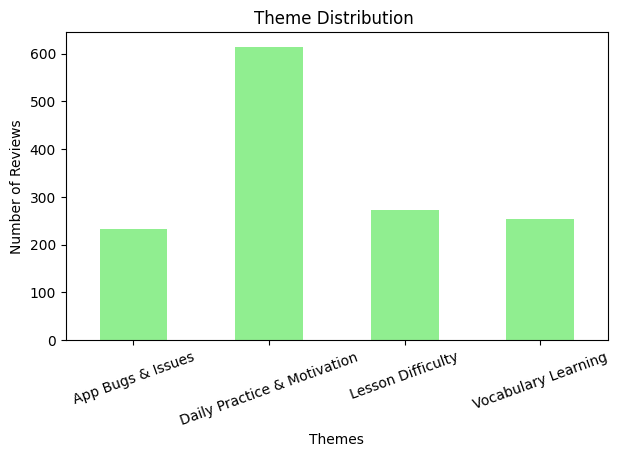


--- Theme Distribution (%) ---
App Bugs & Issues: 16.92%
Daily Practice & Motivation: 44.78%
Lesson Difficulty: 19.84%
Vocabulary Learning: 18.45%


In [17]:
# distribution of reviews across themes 
theme_counts = df['Theme_Name'].value_counts().sort_index()
plt.figure(figsize=(7,4))
theme_counts.plot(kind='bar', color='lightgreen')
plt.title("Theme Distribution ")
plt.xlabel("Themes")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=20)
plt.show()

# also print percentages
pct = (df['Theme_Name'].value_counts(normalize=True) * 100).sort_index()
print("\n--- Theme Distribution (%) ---")
for name, perc in pct.items():
    print(f"{name}: {perc:.2f}%")

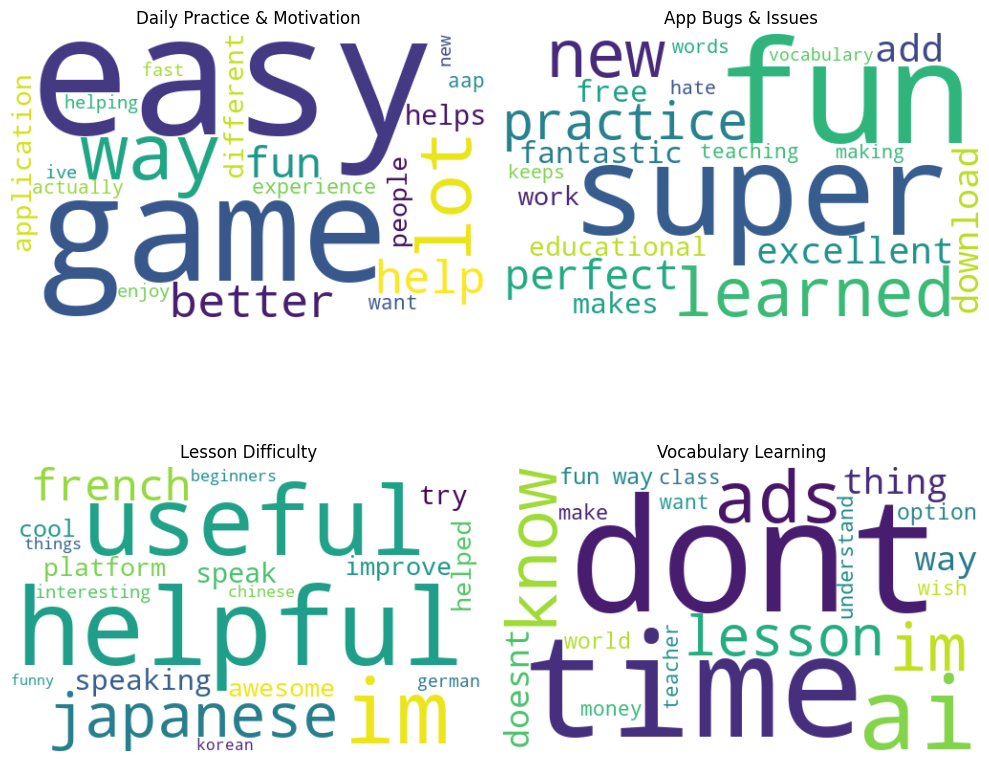

In [18]:
# WordCloud for each theme 
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

for idx, topic in enumerate(lda.components_):
    top_words = {terms[i]: topic[i] for i in topic.argsort()[-20:]}
    wc = WordCloud(width=500, height=300, background_color="white", colormap="viridis")
    wc.generate_from_frequencies(top_words)

    ax = axes[idx]
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"{list(theme_names.values())[idx]}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()
